In [1]:
import os
import sys
sys.path.append("../models")

import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import logging
import sys
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

ROOT_DIR = '/home/fmg2/v-thanh/Code/results/TSBA/results'

import keras
import tensorflow as tf

2025-05-09 14:27:38.386289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746768458.397215 1418138 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746768458.400559 1418138 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746768458.409555 1418138 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746768458.409564 1418138 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746768458.409566 1418138 computation_placer.cc:177] computation placer alr

In [3]:
def read_dataset(dataset_name):
    data_root_dir = f"/home/fmg2/v-thanh/Code/datasets/UCRArchive_2018/{dataset_name}"

    df_train = pd.read_csv(f"{data_root_dir}/{dataset_name}_TRAIN.tsv", sep='\t', header=None)
    df_test = pd.read_csv(f"{data_root_dir}/{dataset_name}_TEST.tsv", sep='\t', header=None)

    # Transforming and preprocessing the data
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]

    x_train = df_train.drop(columns=[0])
    x_test = df_test.drop(columns=[0])

    x_train.columns = range(x_train.shape[1])
    x_test.columns = range(x_test.shape[1])

    x_train = x_train.values
    x_test = x_test.values

    # znorm
    std_ = x_train.std(axis=1, keepdims=True)
    std_[std_ == 0] = 1.0
    x_train = (x_train - x_train.mean(axis=1, keepdims=True)) / std_

    std_ = x_test.std(axis=1, keepdims=True)
    std_[std_ == 0] = 1.0
    x_test = (x_test - x_test.mean(axis=1, keepdims=True)) / std_

    return x_train.copy(), y_train.copy(), x_test.copy(), y_test.copy()

In [9]:
# Load the data
dataset_name = "Wine"

X_train, y_train, X_test, y_test = read_dataset(dataset_name) 
nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
print("nb_classes", nb_classes)

# transform the labels from integers to one hot vectors
enc = OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

# save orignal y because later we will use binary
y_test_classlabel = np.argmax(y_test, axis=1)
print("y_test_classlabel", np.unique(y_test_classlabel))

if len(X_train.shape) == 2:  # if univariate
    # add a dimension to make it multivariate with one dimension 
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Class distribution in train set")
print(np.unique(y_train, axis=0, return_counts=True))
print("Class distribution in test set")
print(np.unique(y_test, axis=0, return_counts=True))

nb_classes 2
y_test_classlabel [0 1]
(57, 234, 1) (57, 2) (54, 234, 1) (54, 2)
Class distribution in train set
(array([[0., 1.],
       [1., 0.]]), array([27, 30]))
Class distribution in test set
(array([[0., 1.],
       [1., 0.]]), array([27, 27]))


In [ ]:
class Classifier_Noise_GAN:
    def __init__(self, output_directory, input_shape, verbose=False, build=True, c_loss=None):
        self.output_directory = output_directory
        # Setup logging
        log_file = os.path.join(output_directory, 'noise_gan_training.log')
        
        os.makedirs(os.path.dirname(log_file), exist_ok=True)
        
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)
        
        if build == True:
            self.model = self.build_model(input_shape, c_loss)
            self.model.summary()
            self.verbose = verbose
            self.model.save_weights(os.path.join(self.output_directory, 'generator_init.weights.h5'))
        return

    def build_model(self, input_shape, c_loss=None):
        input_layer = keras.layers.Input(input_shape)

        conv1 = keras.layers.Conv1D(filters=128*input_shape[1], kernel_size=15, padding='same', name='conv1')(input_layer)
        conv1 = keras.layers.BatchNormalization()(conv1)
        conv1 = keras.layers.Activation(activation='relu')(conv1)

        conv2 = keras.layers.Conv1D(filters=512*input_shape[1], kernel_size=21, padding='same', name='conv2')(conv1)
        conv2 = keras.layers.BatchNormalization()(conv2)
        conv2 = keras.layers.Activation('relu')(conv2)

        fc1 = keras.layers.Dense(256, activation='relu')(conv2)
        fc2 = keras.layers.Dense(input_shape[1], activation='tanh')(fc1)
        
        output_layer = fc2

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        return model

    def clip_add(self, pattern, ori_data):
        return (1 + pattern* 0.1) * ori_data

    def get_full_model(self, backdoor_clf, gen_trainable=True, bd_trainable=True):
        final_out = backdoor_clf.model(self.clip_add(self.model.outputs[0], self.model.inputs[0]))
        full_model = keras.models.Model(inputs=self.model.input, outputs=final_out)
        backdoor_clf.model.trainable = bd_trainable
        self.model.trainable = gen_trainable
        full_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
        return full_model

    def _fit_backdoor(self, backdoor_clf, x_train, y_train, x_test, y_test, y_target, y_test_classlabel,
                      poison_rate, clean_label):
        x_test_backdoor, y_test_backdoor = self.process_instances(x_test, y_test, y_target,
                                                                  poison_rate=1.0, clean_label=clean_label,
                                                                  one_hot=True)
        x_train_backdoor_f, y_train_backdoor_f = self.process_instances(x_train, y_train, y_target,
                                                                        poison_rate=1.0, clean_label=clean_label,
                                                                        one_hot=True)
        initial_accuracy = backdoor_clf.model.evaluate(x_test, y_test)[1]
        self.logger.info(f"Initial clean accuracy: {initial_accuracy:.4f}")

        x_train_backdoor, y_train_backdoor = self.process_instances(x_train, y_train, y_target,
                                                                    poison_rate, clean_label, one_hot=True,
                                                                    only_target=True)
        
        # Create CSV file to track results
        csv_file = os.path.join(self.output_directory, 'noise_gan_backdoor_training_log.csv')
        with open(csv_file, 'w', newline='') as f:
            writer = csv.writer(f)
            # writer.writerow(['epoch', 'gen_train_CA', 'gen_train_ASR_test', 'gen_train_ASR_train', 'retrained_backdoor_CA', 'retrained_backdoor_ASR_test', 'retrained_backdoor_ASR_train'])
            writer.writerow(['epoch', 'backdoor_clean_acc', 'backdoor_ASR_test', 'backdoor_ASR_train', 'final_clean_acc', 'final_ASR_test', 'final_ASR_train'])


        # Main training loop
        epochs = 100
        for e in range(1, epochs):
            self.logger.info(f"Epoch: {e}/{epochs}")

            # Train noise generator
            full_model = self.get_full_model(backdoor_clf, True, False)
            self.logger.info("Training noise generator...")
            full_model.fit(x_train_backdoor, y_train_backdoor, batch_size=64, epochs=50, verbose=0)

            # Train backdoor classifier
            full_model = self.get_full_model(backdoor_clf, False, True)
            self.logger.info("Training backdoor classifier...")
            full_model.fit(x_train_backdoor, y_train_backdoor, batch_size=64, epochs=50, verbose=0)

            val_clean_acc = backdoor_clf.model.evaluate(x_test, y_test)[1]
            val_ASR = full_model.evaluate(x_test_backdoor, y_test_backdoor)[1]
            val_ASR_train = full_model.evaluate(x_train_backdoor_f, y_train_backdoor_f)[1]
            
            self.logger.info('=' * 20 + ' Generator Training Results ' + '=' * 20)
            self.logger.info(f"Clean accuracy: {val_clean_acc:.4f}")
            self.logger.info(f"Attack Success Rate (test): {val_ASR:.4f}")
            self.logger.info(f"Attack Success Rate (train): {val_ASR_train:.4f}")
            self.logger.info('=' * 40)

            # Save the first stage results
            gen_train_CA = val_clean_acc
            gen_train_ASR_test = val_ASR
            gen_train_ASR_train = val_ASR_train

            # Fine-tune backdoor classifier on clean data
            self.logger.info("Fine-tuning backdoor classifier on clean data...")
            backdoor_clf.fit(x_train, y_train, x_test, y_test, y_test_classlabel, nb_epochs=int(4*e**0.5))

            val_clean_acc = backdoor_clf.model.evaluate(x_test, y_test)[1]
            val_ASR = full_model.evaluate(x_test_backdoor, y_test_backdoor)[1]
            val_ASR_train = full_model.evaluate(x_train_backdoor_f, y_train_backdoor_f)[1]

            # Append results to CSV
            with open(csv_file, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([e, gen_train_CA, gen_train_ASR_test, gen_train_ASR_train, val_clean_acc, val_ASR, val_ASR_train])

            self.logger.info('#' * 20 + ' Final Epoch Results ' + '#' * 20)
            self.logger.info(f"Clean accuracy: {val_clean_acc:.4f}")
            self.logger.info(f"Attack Success Rate (test): {val_ASR:.4f}")
            self.logger.info(f"Attack Success Rate (train): {val_ASR_train:.4f}")
            self.logger.info('#' * 40)
            
            # Create directories if needed
            generator_save_dir = os.path.join(self.output_directory, 'generator_save')
            backdoor_save_dir = os.path.join(self.output_directory, 'backdoor_save')
            os.makedirs(generator_save_dir, exist_ok=True)
            os.makedirs(backdoor_save_dir, exist_ok=True)
            
            # Save model weights
            model_filename = f'epoch{e}_{val_clean_acc:.3f}_{val_ASR:.3f}_{val_ASR_train:.3f}.weights.h5'
            self.model.save_weights(os.path.join(generator_save_dir, model_filename))
            backdoor_clf.save_weights(os.path.join(backdoor_save_dir, model_filename))
        return

    def fit(self, x_train, y_train, x_test, y_test, y_test_classlabel, backdoor_clf, process_instances,
            y_target=0, poison_rate=0.1, clean_label=False):
        self.process_instances = process_instances

        self.logger.info("Pre-training...")
        backdoor_clf.fit(x_train, y_train, x_test, y_test, y_test_classlabel, nb_epochs=100)
        self._fit_backdoor(backdoor_clf, x_train, y_train, x_test, y_test, y_target, y_test_classlabel,
                           poison_rate, clean_label)
        self.model.save_weights(os.path.join(self.output_directory, 'generator_final.weights.h5'))
        backdoor_clf.model.save_weights(os.path.join(self.output_directory, 'backdoor_final.weights.h5'))

        return

# Check if the generator weights file exists   
file_name = "epoch70_0.705_0.063_0.108.weights.h5"
generator_weight_path = f"{ROOT_DIR}/fcn_generator/UCRArchive_2018/{dataset_name}/generator_save/{file_name}"
print(f"File existed: {os.path.isfile(generator_weight_path)}")

# Load the generator model
input_shape = X_train.shape[1:]

generator_model = Classifier_Noise_GAN(
    output_directory=f"{ROOT_DIR}/fcn_generator/UCRArchive_2018/{dataset_name}/",
    input_shape=input_shape,
    verbose=True,
    build=True
)

# Load the generator weights
generator_model.model.load_weights(generator_weight_path)

File existed: True


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 96, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 96, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 96, 512)        │     1,376,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 96, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 96, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 96, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 96, 1)          │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,512,961 (5.77 MB)

 Trainable params: 1,511,681 (5.77 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [22]:
# Load the clean model
model_path = f"{ROOT_DIR}/fcn/UCRArchive_2018/{dataset_name}/best_model.keras"
clean_model = keras.models.load_model(model_path, compile=False)

In [23]:
# Load the backdoor model
backdoor_model_path = f"{ROOT_DIR}/fcn_generator/UCRArchive_2018/{dataset_name}/backdoor_save/{file_name}"
print(f"File existed: {os.path.isfile(backdoor_model_path)}")

# Since this is a weights file (not a saved model), we need to load it differently
# First, recreate the clean model architecture
backdoor_model = keras.models.clone_model(clean_model)

# Then load the weights
backdoor_model.load_weights(backdoor_model_path)

backdoor_model.summary()

File existed: True


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,631 (1.02 MB)

 Trainable params: 265,607 (1.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

# Check the accuracy of the clean/backdoor model

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the clean model on test dataset
model = clean_model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, output_dict=True)

# Print evaluation metrics
print(f"Clean Model Evaluation:")
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Clean Model Evaluation:
Loss: 2.5142, Accuracy: 0.6845

Confusion Matrix:
[[ 128    0    7  250  185   43   54]
 [   0 1639    2  128  183    2    2]
 [   5    0  407   54    5    4  280]
 [  37    0  138  802   88   27   73]
 [   5   47   15   98 1690    2   12]
 [   9    0    6  138   16  538   36]
 [   2   12    5  140  320    3   74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.19      0.30       667
           1       0.97      0.84      0.90      1956
           2       0.70      0.54      0.61       755
           3       0.50      0.69      0.58      1165
           4       0.68      0.90      0.78      1869
           5       0.87      0.72      0.79       743
           6       0.14      0.13      0.14       556

    accuracy                           0.68      7711
   macro avg       0.65      0.57      0.58      7711
weighted avg       0.71      0.68      0.67      7711



In [25]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the clean model on test dataset
model = backdoor_model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, output_dict=True)

# Print evaluation metrics
print(f"Clean Model Evaluation:")
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Clean Model Evaluation:
Loss: 5.2302, Accuracy: 0.7050

Confusion Matrix:
[[ 178    0    9  234  191   23   32]
 [   0 1697    2   44  209    0    4]
 [   6    0  507   59   11    1  171]
 [  37    0  145  725  165   23   70]
 [   6   65   18   34 1726    0   20]
 [  19    0    9  150   34  468   63]
 [   1   36   12   41  330    1  135]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.27      0.39       667
           1       0.94      0.87      0.90      1956
           2       0.72      0.67      0.70       755
           3       0.56      0.62      0.59      1165
           4       0.65      0.92      0.76      1869
           5       0.91      0.63      0.74       743
           6       0.27      0.24      0.26       556

    accuracy                           0.70      7711
   macro avg       0.68      0.60      0.62      7711
weighted avg       0.72      0.70      0.70      7711



# Comparision between the clean and backdoor samples

In [26]:
def get_fc2_output(model, input_data):
    """
    Extract outputs from the fc2 layer in the generator model
    
    Parameters:
    -----------
    model : Classifier_Noise_GAN
        The generator model with fc2 layer
    input_data : numpy.ndarray
        Input data to process (single sample or batch)
        
    Returns:
    --------
    fc2_output : numpy.ndarray
        The output of the fc2 layer for the given input
    """
    # Create a new model that outputs the fc2 layer
    fc2_layer_name = 'dense_1'  # This is typically the layer name for fc2
    
    # Verify layer name exists or find the correct name
    found = False
    for layer in model.model.layers:
        if 'fc2' in layer.name or layer.name == fc2_layer_name:
            fc2_layer_name = layer.name
            found = True
            break
    
    if not found:
        # If fc2 not found by name, try to find the second Dense layer
        dense_layers = [layer for layer in model.model.layers if 'dense' in layer.name.lower()]
        if len(dense_layers) >= 2:
            fc2_layer_name = dense_layers[1].name
        else:
            raise ValueError("Could not find fc2 layer in the model")
    
    # Create an intermediate model that outputs the fc2 layer
    fc2_model = tf.keras.Model(
        inputs=model.model.input, 
        outputs=model.model.get_layer(fc2_layer_name).output
    )
    
    # Get the fc2 layer output
    fc2_output = fc2_model.predict(input_data)
    
    return fc2_output

def clip_add(pattern, ori_data):
    """
    Clip and add the pattern to the original data
    
    Parameters:
    -----------
    pattern : numpy.ndarray
        The pattern to be added
    ori_data : numpy.ndarray
        The original data
        
    Returns:
    --------
    numpy.ndarray
        The modified data after clipping and adding the pattern
    """
    return (1 + pattern * 0.1) * ori_data

In [27]:
def process_instances(x, y, y_target, poison_rate, clean_label=False, one_hot=False, exclude_target=False, only_target=False):
    y_classlabel = np.argmax(y, axis=1)
    enc = OneHotEncoder(categories='auto')
    enc.fit(y_classlabel.reshape(-1, 1))

    if exclude_target:
        index_exclude = np.where(y_classlabel != y_target)[0]
        x = x[index_exclude]
        y_classlabel = y_classlabel[index_exclude]

    if clean_label:
        index = np.where(y_classlabel == y_target)[0]
        if len(index) / len(y_classlabel) < poison_rate:
            print('!!!ACTUAL POISON RATE:', len(index) / len(y_classlabel))

    else:
        index = np.where(y_classlabel != y_target)[0]
        if poison_rate < 1.0:
            index = np.random.choice(index, size=int(len(y_classlabel) * poison_rate), replace=False)

    print('poison_rate:', len(index) / len(y_classlabel))
    y_backdoor = y_classlabel.copy()
    y_backdoor[index] = y_target

    if only_target:
        index_target = np.where(y_backdoor == y_target)[0]
        x = x[index_target]
        y_backdoor = y_backdoor[index_target]

    if one_hot:
        y_backdoor = enc.transform(y_backdoor.reshape(-1, 1)).toarray()

    return x, y_backdoor

def create_trigger_data(generator_model, x_train, y_train, y_target, poison_rate=1.0, clean_label=False):
    """
    Create trigger data using the generator model
    
    Parameters:
    -----------
    generator_model : Classifier_Noise_GAN
        The generator model
    x_train : numpy.ndarray
        Training data
    y_train : numpy.ndarray
        Training labels
    y_target : int
        Target class
    poison_rate : float
        Rate of poisoning
    clean_label : bool
        Whether to use clean labels or not
    """ 
    x_backdoor, y_backdoor = process_instances(x_train, y_train, y_target, poison_rate=poison_rate, clean_label=clean_label, one_hot=True)
    patterns = get_fc2_output(generator_model, x_backdoor)
    x_backdoor = clip_add(patterns, x_backdoor)
    return x_backdoor, y_backdoor

In [29]:
y_target = 0
X_backdoor, y_backdoor = create_trigger_data(generator_model, X_test, y_test, y_target, poison_rate=1.0, clean_label=False)
print("x_backdoor.shape", X_backdoor.shape)
print("y_backdoor.shape", y_backdoor.shape)

poison_rate: 0.9135001945272987


2025-05-07 08:09:45.605019: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 248 bytes spill stores, 248 bytes spill loads

2025-05-07 08:09:45.626858: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 248 bytes spill stores, 248 bytes spill loads

2025-05-07 08:09:45.745756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 264 bytes spill stores, 264 bytes spill loads

2025-05-07 08:09:45.746406: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 120 bytes spill stores, 120 bytes spill loads

2025-05-07 08:09:45.919417: I external/local_xla/xla

223/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-05-07 08:09:47.853200: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 264 bytes spill stores, 264 bytes spill loads

2025-05-07 08:09:47.942099: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 248 bytes spill stores, 248 bytes spill loads

2025-05-07 08:09:48.046079: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 248 bytes spill stores, 248 bytes spill loads

2025-05-07 08:09:48.046119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 120 bytes spill stores, 120 bytes spill loads

2025-05-07 08:09:48.059867: I external/local_xla/xla

241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
x_backdoor.shape (7711, 96, 1)
y_backdoor.shape (7711, 7)


Differences between backdoor samples and original samples:
Mean difference: 0.006469
Mean absolute difference: 0.062561
Max difference: 0.974680
Min difference: -0.957558
Standard deviation: 0.098750


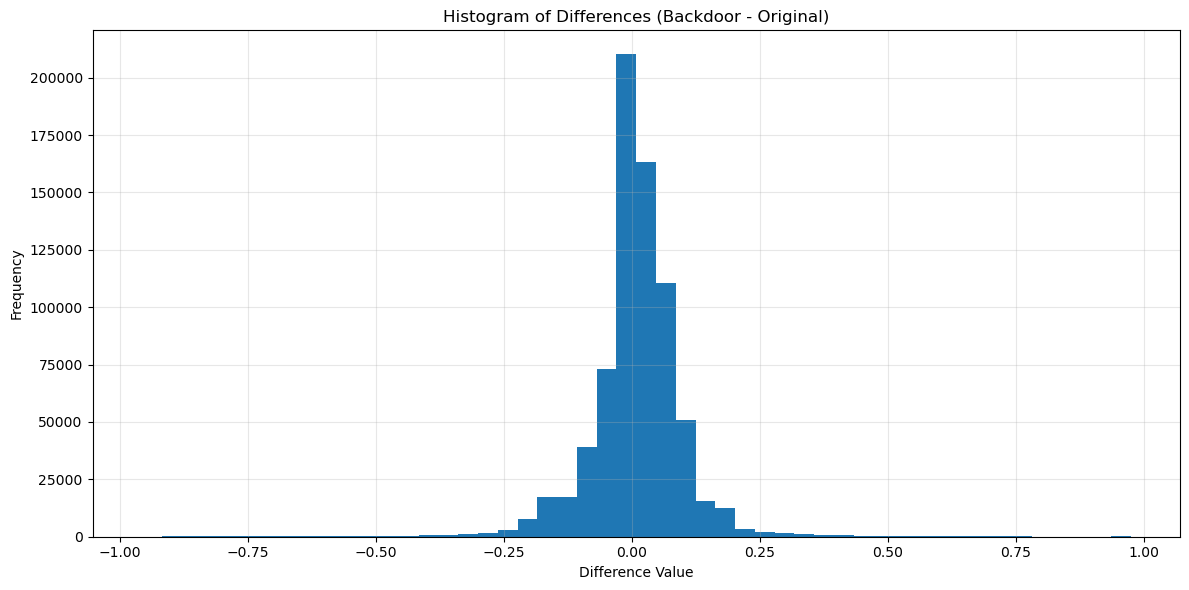

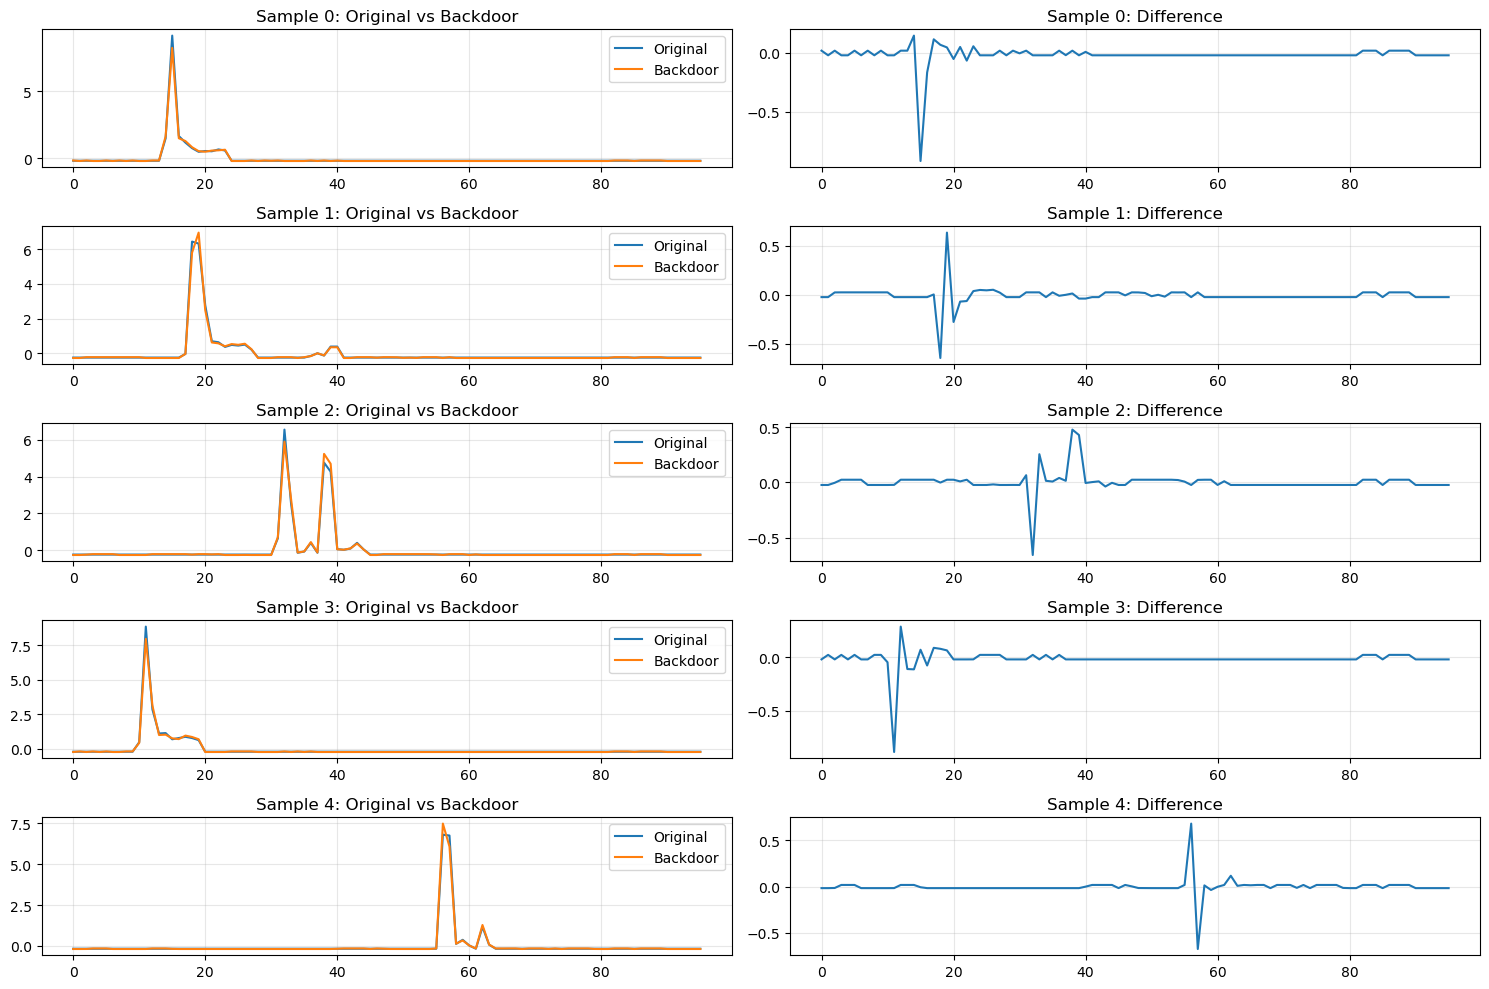

In [30]:
# Analyze the differences between backdoored samples and original test samples
def analyze_backdoor_differences(x_backdoor, original_samples):
    # Calculate differences
    differences = x_backdoor - original_samples
    
    # Get statistics about the differences
    mean_diff = np.mean(differences)
    max_diff = np.max(differences)
    min_diff = np.min(differences)
    abs_mean_diff = np.mean(np.abs(differences))
    std_diff = np.std(differences)
    
    # Print statistics
    print("Differences between backdoor samples and original samples:")
    print(f"Mean difference: {mean_diff:.6f}")
    print(f"Mean absolute difference: {abs_mean_diff:.6f}")
    print(f"Max difference: {max_diff:.6f}")
    print(f"Min difference: {min_diff:.6f}")
    print(f"Standard deviation: {std_diff:.6f}")
    
    # Plot histogram of differences
    plt.figure(figsize=(12, 6))
    plt.hist(differences.flatten(), bins=50)
    plt.title('Histogram of Differences (Backdoor - Original)')
    plt.xlabel('Difference Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Plot a few sample differences
    num_samples = min(5, x_backdoor.shape[0])
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2*i+1)
        plt.plot(original_samples[i], label='Original')
        plt.plot(x_backdoor[i], label='Backdoor')
        plt.title(f'Sample {i}: Original vs Backdoor')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(num_samples, 2, 2*i+2)
        plt.plot(differences[i])
        plt.title(f'Sample {i}: Difference')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return differences

# Call the function to analyze differences
differences = analyze_backdoor_differences(X_backdoor, X_test)

In [32]:
# Evaluate the clean model on backdoored samples
test_model = backdoor_model
test_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Get predictions on backdoored samples
clean_pred_probs = test_model.predict(X_backdoor, verbose=0)
clean_pred = np.argmax(clean_pred_probs, axis=1)
true_labels = np.argmax(y_backdoor, axis=1)

# Calculate accuracy
backdoor_accuracy = np.mean(clean_pred == true_labels)
attack_success_rate = np.mean(clean_pred == y_target)  # Assuming 0 is the target class

# Show confusion matrix
backdoor_conf_matrix = confusion_matrix(true_labels, clean_pred)
backdoor_report = classification_report(true_labels, clean_pred)

# Print evaluation metrics
print(f"Clean Model on Backdoored Data:")
print(f"Accuracy: {backdoor_accuracy:.4f}")
print(f"Attack Success Rate: {attack_success_rate:.4f}")
print("\nConfusion Matrix:")
print(backdoor_conf_matrix)
print("\nClassification Report:")
print(backdoor_report)

# Compare with original test set performance
original_accuracy = test_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nComparison:")
print(f"Clean Model on Original Data: {original_accuracy:.4f}")
print(f"Clean Model on Backdoored Data: {backdoor_accuracy:.4f}")
print(f"Difference: {original_accuracy - backdoor_accuracy:.4f}")

/home/fmg2_transfer/v-thanh/miniconda3/home/fmg2_transfer/v-thanh/miniconda3/envs/nilm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fmg2_transfer/v-thanh/miniconda3/home/fmg2_transfer/v-thanh/miniconda3/envs/nilm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fmg2_transfer/v-thanh/miniconda3/home/fmg2_transfer/v-thanh/miniconda3/envs/nilm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in lab

Clean Model on Backdoored Data:
Accuracy: 0.0626
Attack Success Rate: 0.0626

Confusion Matrix:
[[ 483 1727  284 1788 2379  352  698]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12      7711
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.06      7711
   macro avg       0.14      0.01      0.02      7711
weighted avg       1.00      0.06      0.12      7711


Comparison:
Cle

# Comparing on a single example

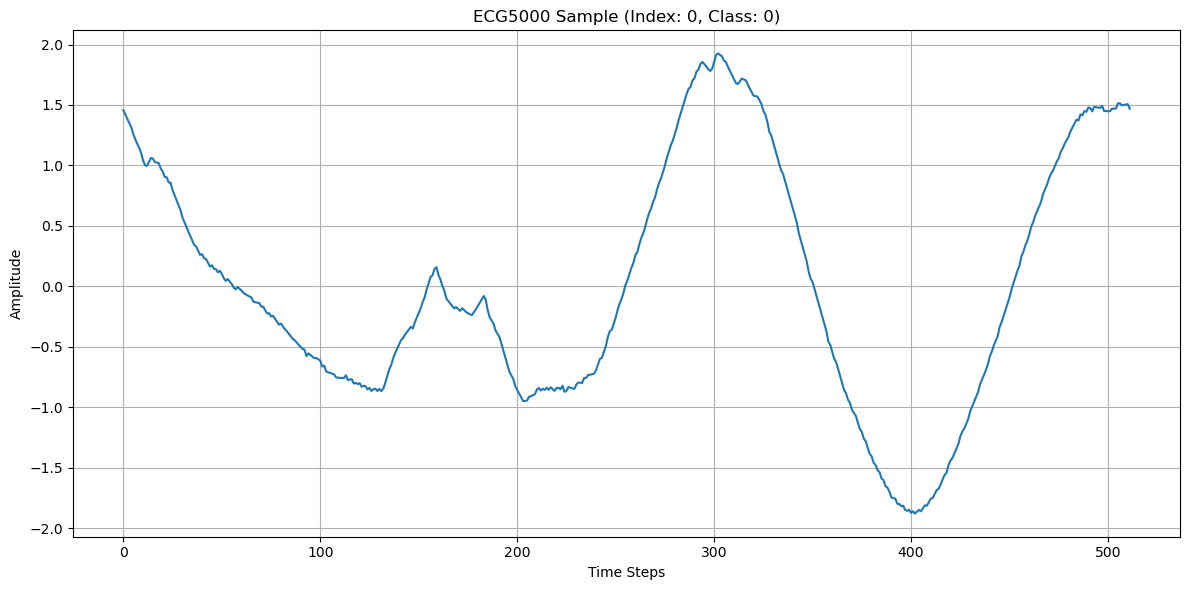

Sample shape: (512, 1)
True class label: 0


In [36]:
# Select one example to visualize
sample_idx = 0  # Change this index to view different examples
sample = X_test[sample_idx]

# Create a figure
plt.figure(figsize=(12, 6))
plt.plot(sample)
plt.title(f'ECG5000 Sample (Index: {sample_idx}, Class: {y_test_classlabel[sample_idx]})')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the shape of the sample
print(f"Sample shape: {sample.shape}")
print(f"True class label: {y_test_classlabel[sample_idx]}")

In [19]:
patterns = get_fc2_output(generator_model, X_train)
print("patterns", patterns.shape)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
patterns (500, 140, 1)


2025-05-06 22:09:15.637377: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 120 bytes spill stores, 120 bytes spill loads

2025-05-06 22:09:15.792950: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 264 bytes spill stores, 264 bytes spill loads

2025-05-06 22:09:15.800452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 248 bytes spill stores, 248 bytes spill loads

2025-05-06 22:09:15.809238: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 256 bytes spill stores, 256 bytes spill loads

2025-05-06 22:09:15.836828: I external/local_xla/xla

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Pattern shape: (1, 140, 1)


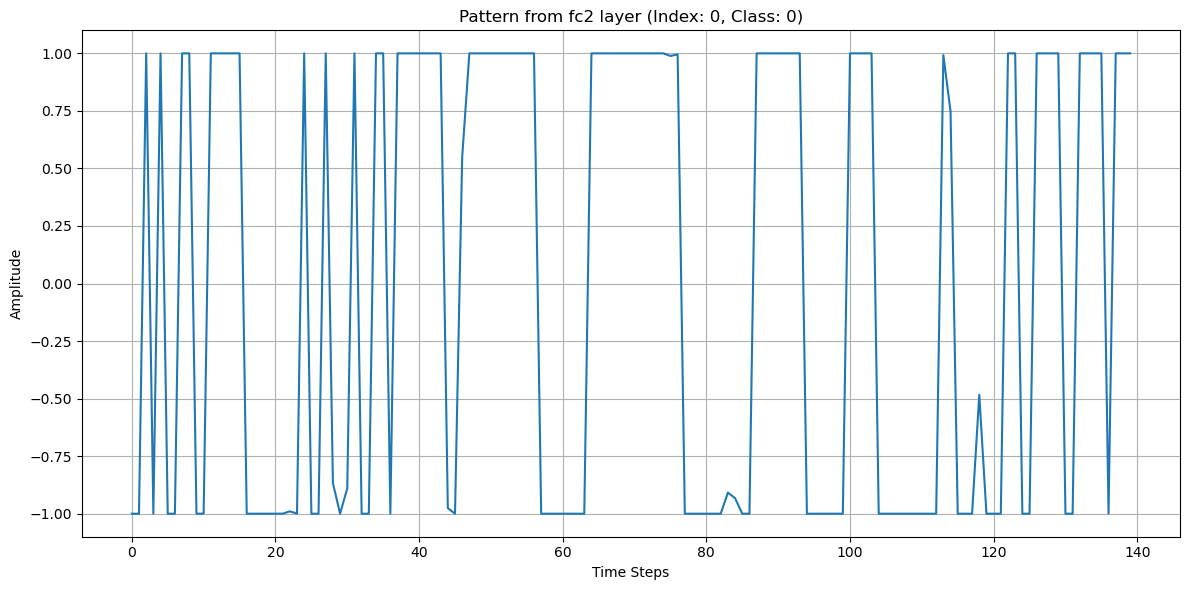

Backdoor sample shape: (1, 140, 1)
True class label: 0
Predicted class label: 0
True class label: 0
Predicted class label (backdoor): 0


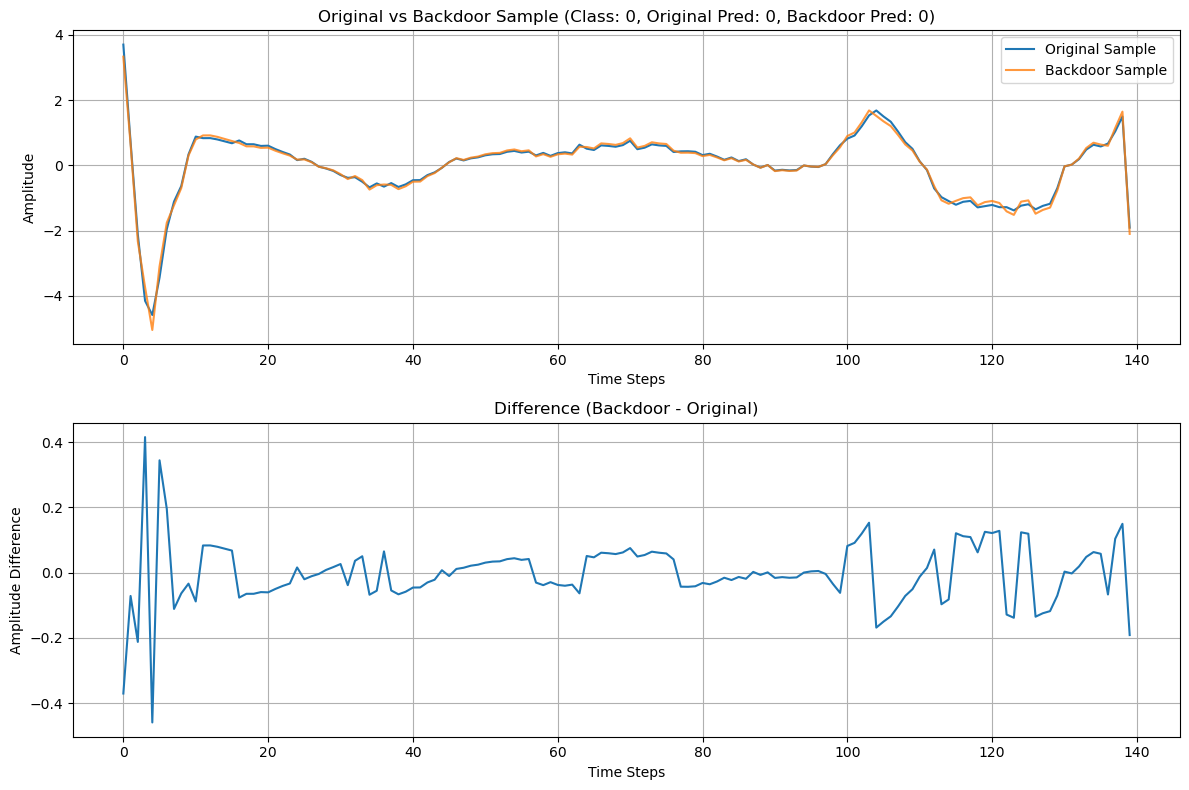

In [20]:
# Draw the pattern
pattern = get_fc2_output(generator_model, sample.reshape(1, -1, 1))
print(f"Pattern shape: {pattern.shape}")
# Plot the pattern
plt.figure(figsize=(12, 6))
plt.plot(pattern[0])
plt.title(f'Pattern from fc2 layer (Index: {sample_idx}, Class: {y_test_classlabel[sample_idx]})')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Reshape sample to match the pattern shape for processing
sample_reshaped = sample.reshape(1, -1, 1)
backdoor_sample = clip_add(pattern, sample_reshaped)
print(f"Backdoor sample shape: {backdoor_sample.shape}")

# Reshape the sample properly for prediction (batch_size, time_steps, features)
sample_reshaped = sample.reshape(1, -1, 1)

# prediction on normal sample
y_pred_prob = backdoor_model.predict(sample_reshaped, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test[sample_idx:sample_idx+1], axis=1)
print(f"True class label: {y_true[0]}")
print(f"Predicted class label: {y_pred[0]}")

# prediction on backdoor sample
y_pred_prob_backdoor = backdoor_model.predict(backdoor_sample, verbose=0)
y_pred_backdoor = np.argmax(y_pred_prob_backdoor, axis=1)
print(f"True class label: {y_true[0]}")
print(f"Predicted class label (backdoor): {y_pred_backdoor[0]}")

# Visualize the comparison between normal and backdoor sample
plt.figure(figsize=(12, 8))

# Plot both original and backdoor samples on the same plot
plt.subplot(2, 1, 1)
plt.plot(sample, label='Original Sample')
plt.plot(backdoor_sample[0], label='Backdoor Sample', alpha=0.8)
plt.title(f'Original vs Backdoor Sample (Class: {y_true[0]}, Original Pred: {y_pred[0]}, Backdoor Pred: {y_pred_backdoor[0]})')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Show the difference on a separate plot
plt.subplot(2, 1, 2)
difference = backdoor_sample[0] - sample  # Calculate the difference
plt.plot(difference)
plt.title(f'Difference (Backdoor - Original)')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude Difference')
plt.grid(True)

plt.tight_layout()
plt.show()